导入头文件

In [3]:
from keras.layers import Input,Convolution2D,MaxPooling2D,UpSampling2D
from keras.layers import normalization
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.
/home/hc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
def show(target):
    n = 10
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(target[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

计算psnr

In [5]:
def cal_psnr(im1,im2):
    mse = (np.abs(im1-im2)**2).mean()
    psnr = 10*np.log10(255*255/mse)
    return psnr

导入数据

In [6]:
(X_train,_),(X_test,_) = mnist.load_data()

数据进行归一化

In [7]:
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

转换数据格式

In [8]:
X_train = np.reshape(X_train,(len(X_train),28,28,1))
X_test = np.reshape(X_test,(len(X_test),28,28,1))

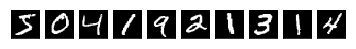

In [9]:
show(X_train)

对图片增加噪声

In [12]:
noise_factor = 0.5
X_train_noisy = X_train+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=X_train.shape)
X_test_noisy = X_test+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy,0.,1.)
X_train_noisy = np.clip(X_train_noisy,0.,1.)

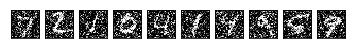

In [13]:
show(X_test_noisy)

构建模型


In [14]:
input_img = Input(shape=(28,28,1))

#### 自编码神经网络
编码层

In [15]:
x = Convolution2D(32,(3,3),activation='relu',padding='same')(input_img)

In [16]:
x = MaxPooling2D((2,2),padding='same')(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
encoded = MaxPooling2D((2,2),padding='same')(x)

解码层

In [17]:
x = Convolution2D(32,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1,(3,3),activation='relu',padding='same')(x)

In [18]:
autoencoder = Model(inputs=input_img,outputs=decoded)

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 32)          9248      
__________

In [20]:
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')

In [22]:
hist=autoencoder.fit(X_train_noisy,X_train,epochs=2,batch_size=256,shuffle=True,validation_data=(X_test_noisy,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 4s 59us/step - loss: 0.1490 - val_loss: 0.1431
Epoch 2/2
60000/60000 [==============================] - 4s 61us/step - loss: 0.1451 - val_loss: 0.1400


In [26]:
score = autoencoder.evaluate(X_test_noisy,X_test,batch_size=128)

10000/10000 [==============================] - 0s 41us/step


In [27]:
print(score)

0.14002469492


预测图片

In [28]:
decoded_imgs = autoencoder.predict(X_test_noisy)

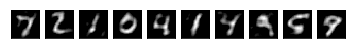

In [29]:
show(decoded_imgs)

计算psnr

In [30]:
out_imgs_data=np.clip(255*decoded_imgs,0,255).astype('float32')
X_test_data = np.clip(255*X_test,0,255).astype('float32')

In [31]:
print('psnr is :',cal_psnr(X_test_data,out_imgs_data))

psnr is : 16.3405184164
